# Capstone 3.2 - Kmeans Clustering

In [105]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import os 
import seaborn as sns
os.chdir(r'C:\Users\nmur1\Google Drive\Springboard\Capstone3\CleanData')

In [106]:

pvtMonthlyChg = pd.read_pickle('Monthly_Housing')
chg_by_month = pvtMonthlyChg.values

In [107]:
chg_by_month

array([[ 0.        ,  0.00149286,  0.00371726, ...,  0.00654776,
         0.00806779,  0.00876543],
       [ 0.        , -0.00132415, -0.0007306 , ...,  0.00381042,
         0.00690652,  0.00669931],
       [ 0.        , -0.00258303, -0.00050181, ...,  0.00578617,
         0.01139701,  0.01550102],
       ...,
       [ 0.        ,  0.00932063,  0.0122802 , ..., -0.00626106,
        -0.0105859 , -0.00558114],
       [ 0.        ,  0.0080416 ,  0.01129107, ..., -0.00459774,
        -0.00668021, -0.00874079],
       [ 0.        ,  0.0030347 ,  0.00509931, ...,  0.01020988,
         0.00945612,  0.00403364]])

## Define K means clustering functions 

In [108]:
def kelbow(df):

    ks = range(1, 25)
    inertias = []

    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters = k)

        # Fit model to samples
        model.fit(df)

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    # Plot ks vs inertias
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

In [109]:
def kPCA(df):
    pca = PCA()
    pca.fit(df)

    # Plot the explained variances
    features = range(pca.n_components_)
    plt.figure(figsize=(20,10))
    plt.bar(features, pca.explained_variance_)
    plt.xlabel('PCA feature')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()


    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [110]:
def clustermap(df, clusters):
    # Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
    model = KMeans(n_clusters=clusters)

    # Call a fit_predict() on X 
    cluster_assignments = model.fit_predict(df)

    # Let's visualiaze with colors.ListedColormap
    #cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'purple'])

    #labels = range(0,4)
    # We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
    pca = PCA(n_components=2)
    pc1, pc2 = zip(*pca.fit_transform(df))
    plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), alpha = .5)

In [111]:
#kelbow(chg_by_month)

In [112]:
#kPCA(chg_by_month)

### Based on initial clustering analysis k = 3 or 4 seems to be the appropriate amount of clusters
### Using PCA to graph out the clusters we can see that 3 offers near perfect segmentation while 4 has some overlap


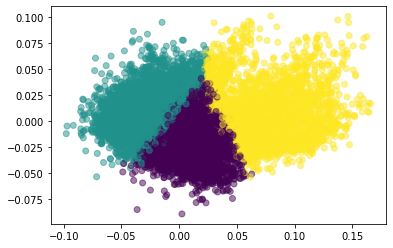

In [113]:
clustermap(chg_by_month,3)

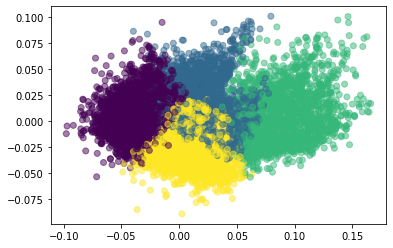

In [114]:
clustermap(chg_by_month,4)

### While there is some overlap between green and yellow clusters, I'll start with setting k = 4 for initial clustering

In [115]:
#I'll use 4 clusters for the segmentation

kmeans = KMeans(n_clusters = 4, random_state = 0
               )
# Predict the cluster labels: labels
labels = kmeans.fit_predict(chg_by_month)

# Create a DataFrame aligning labels and companies: df
df = pd.DataFrame({'ZipCode': pvtMonthlyChg.index,'labels': labels})

# Display df sorted by cluster label
clustered = pvtMonthlyChg.reset_index().merge(df, on = 'ZipCode')


c_melt = clustered.melt(id_vars = ['ZipCode', 'labels'], var_name = 'Date',value_name = 'Price')


#### Based on the below statistical summary and graph, we can see that the k means algorithm did a decent job clustering the zip codes by monthly volatility over the past 25 years.

#### cluster 2 exibits the least volatility. Averaging a monthly increase of .24 points with a range of less than 1% and a standard deviation of .22%


In [116]:
c_melt_monthly = c_melt.groupby(['Date','labels'])['Price'].mean().reset_index()
c_melt_monthly.Date = pd.to_datetime(c_melt_monthly.Date)

In [117]:
avg = c_melt_monthly.groupby('labels')['Price'].mean()
med = c_melt_monthly.groupby('labels')['Price'].median()
min_ = c_melt_monthly.groupby('labels')['Price'].min()
max_ = c_melt_monthly.groupby('labels')['Price'].max()
std_ = c_melt_monthly.groupby('labels')['Price'].std()

summary = pd.DataFrame([avg,med,min_,max_,std_]).T * 100
summary.columns = ['Average', 'Median', 'Min', 'Max', 'Deviation']
summary = round(summary,2)
summary['Range'] = summary.Max - summary.Min
summary

,Average,Median,Min,Max,Deviation,Range
labels,,,,,,
0,0.29,0.26,-0.72,1.29,0.47,2.01
1,0.32,0.47,-1.09,1.03,0.51,2.12
2,0.38,0.58,-2.13,1.92,0.88,4.05
3,0.24,0.32,-0.37,0.54,0.21,0.91


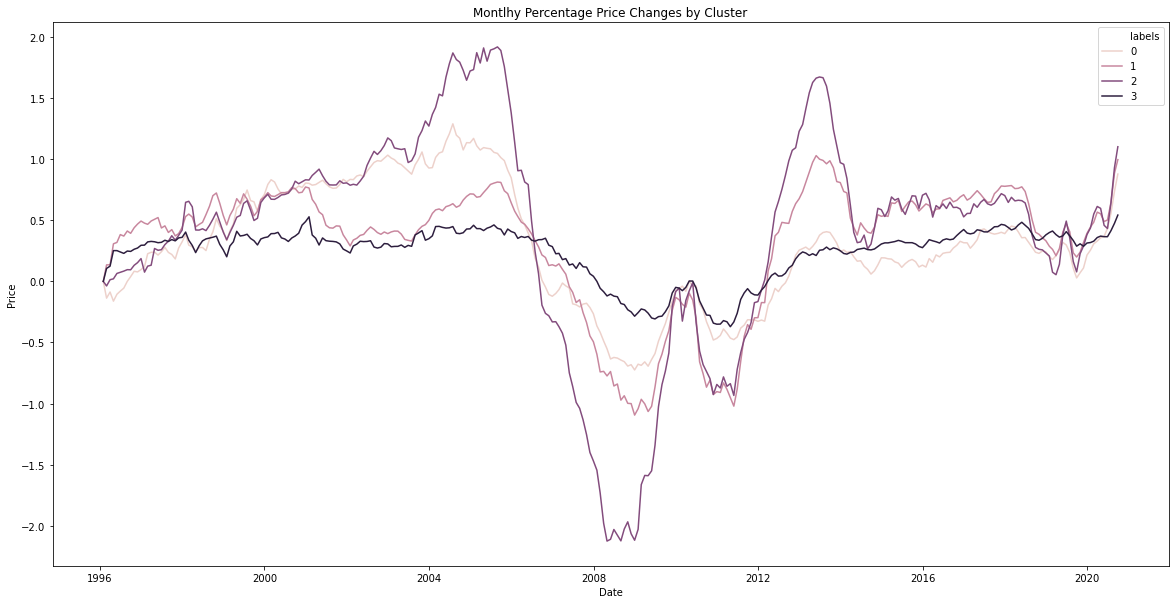

In [118]:
monthly_cluster = c_melt.groupby(['Date','labels'])['Price'].mean().reset_index()
monthly_cluster.Date = pd.to_datetime(monthly_cluster.Date)
monthly_cluster.Price = monthly_cluster.Price * 100
monthly_cluster.to_csv('Cluster_Analysis.csv')
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
plt.figure(figsize = (20,10))
plt.title('Montlhy Percentage Price Changes by Cluster')
ax = sns.lineplot(x = 'Date', y = 'Price', data = monthly_cluster, hue = 'labels', color='summer')
plt.show()

#### Based on the initial clustering analysis cluster 2 appears to be the most stable environment to invest in
#### Given it's relative predictability it's also a prime candidate for time series forecasting

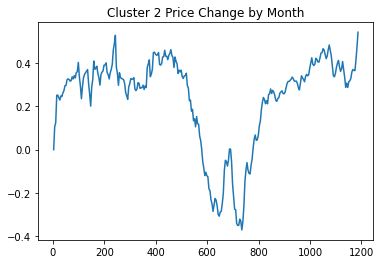

In [119]:
#plot cluster 2 by itself

plt.title('Cluster 2 Price Change by Month')
df = monthly_cluster[monthly_cluster.labels == 3]
df['Price'].plot()

### Test Time Stationarity of Time Series using a Dicky Fuller Test

In [120]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
   
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.436075
p-value                          0.564864
#Lags Used                      16.000000
Number of Observations Used    280.000000
Critical Value (1%)             -3.453922
Critical Value (5%)             -2.871918
Critical Value (10%)            -2.572300
dtype: float64


### Given our test stat is greater than all 3 critical values and the p value is much larger than .05 we can determine that the series is not stationary and differencing will need to be applied

I'll plot the original series and ACF along with the first 2 orders of differencing


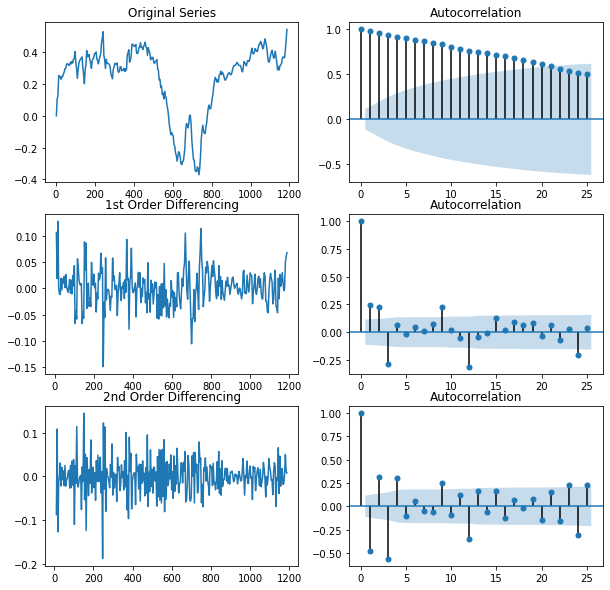

In [121]:


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, figsize = (10,10))

axes[0, 0].plot(df['Price']); axes[0, 0].set_title('Original Series')
plot_acf(df['Price'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Price'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Price'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Price'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Price'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [122]:
#the above analysis indicates that we can use 1 or 2 orders of differening
#I'll validate this with another ADF test on the differenced set
# p value well under .05 and test stat is less than critical values of .05 and .10

adf_test(df['Price'].diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.061805
p-value                          0.029512
#Lags Used                      16.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


Next we need to determin the p and q arguments to be used in the Arima model

We can define appropriate values for our AR (lag) by using a pacf plot
Based on the below an AR term of 1 or 2 is statistically significant


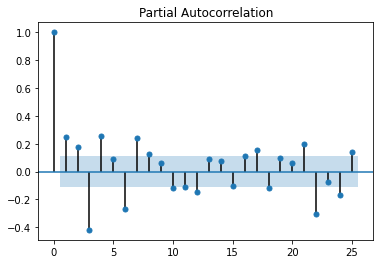

In [123]:
#PACF plot indicates an appropriate p of 1, 2, or 3

_ = plot_pacf(df['Price'].diff().dropna())

Next we'll evaluate the q argument or Moving Average term using a acf plot
lags of 1, 2, and 3 are all statistically significant

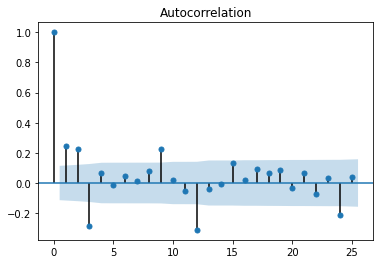

In [124]:
#ACF indicates 1, 2, or 3 for the q value 

_ = plot_acf(df['Price'].diff().dropna())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  296
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 668.402
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sat, 28 Nov 2020   AIC                          -1326.804
Time:                        23:17:42   BIC                          -1308.352
Sample:                             1   HQIC                         -1319.416
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.003      0.677      0.498      -0.004       0.008
ar.L1.D.Price    -0.5045      0.053     -9.547      0.000      -0.608      -0.401
ma.L1.D.Price     1.0322      0.013     

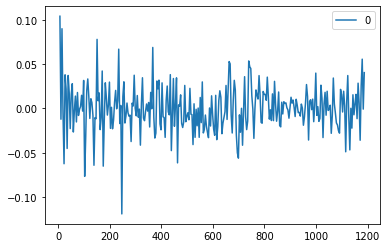

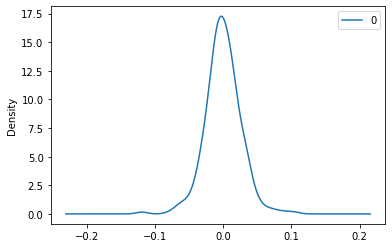

                0
count  296.000000
mean     0.000108
std      0.025930
min     -0.119007
25%     -0.014270
50%     -0.000570
75%      0.014833
max      0.104058


In [125]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf


# fit model
model = ARIMA(df['Price'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Testing the Arima Model

PACF and ACF analysis indicated that values of d = [1,2], q = [1,2,3], and p = [1,2] are all appropriate candidates for the model

The below functions will test the accuracy of these using a 75/25 train test split

In [126]:
def ArimaVal(df, pdq, train):    

    p = pdq[0]
    d = pdq[1]
    q = pdq[2]
    
    
    n = int(round(len(df) * train))
    n2 = len(df) - n
    # Create Training and Test
    train = df['Price'][:n]
    test = df['Price'][n:]

    # Build Model
    # model = ARIMA(train, order=(3,2,1))  
    model = ARIMA(train, order=(p,d,q))  
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(n2, alpha=0.10)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    return (forecast_accuracy(fc, test.values, pdq))

# Accuracy metrics
def forecast_accuracy(forecast, actual, pdq):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'pdq_val':str(pdq), 'mape':round(mape,3), 'me':round(me,3), 'mae': round(mae,3), 
            'mpe': round(mpe,3), 'rmse':round(rmse,3), 
            'corr':round(corr,3), 'minmax':round(minmax,3)})


In [127]:
# create list with pdq combinatiosn
import itertools
import warnings
p = range(1,3)
d = range(1,3)
q = range(1,4)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
warnings.filterwarnings("ignore")



In [128]:
dfs = []
for n in pdqs:
    try:
        dfs.append(pd.DataFrame(ArimaVal(df, n, .9), index = [1]))
    except:
        print('N/A')
        
        
accuracy_metrics = pd.concat(dfs).sort_values(by = 'mape')

N/A
N/A
N/A


In [129]:
accuracy_metrics

,pdq_val,mape,me,mae,mpe,rmse,corr,minmax
1,"(2, 2, 2)",0.234,0.069,0.082,0.208,0.092,-0.186,0.179
1,"(1, 2, 2)",0.235,0.068,0.082,0.207,0.092,-0.394,0.180
1,"(1, 1, 1)",0.263,0.081,0.091,0.243,0.103,-0.145,0.195
1,"(2, 1, 1)",0.265,0.082,0.092,0.244,0.104,-0.154,0.196
1,"(1, 2, 1)",0.271,0.081,0.094,0.245,0.106,-0.665,0.201
1,"(2, 2, 1)",0.283,0.087,0.098,0.260,0.110,-0.587,0.207
1,"(1, 1, 3)",0.313,0.105,0.108,0.306,0.122,-0.142,0.222
1,"(1, 2, 3)",0.337,0.115,0.117,0.333,0.132,-0.151,0.234
1,"(1, 1, 2)",0.341,0.116,0.118,0.337,0.133,-0.157,0.236


In [130]:
def ArimaModel(df,pdq, train):    


    p = pdq[0]
    d = pdq[1]
    q = pdq[2]
    
    n = int(round(len(df) * train))
    n2 = len(df) - n
    # Create Training and Test
    train = df['Price'][:n]
    test = df['Price'][n:]

    # Build Model
    # model = ARIMA(train, order=(3,2,1))  
    model = ARIMA(train, order=(p,d,q))  
    fitted = model.fit(disp=0)  

    # Forecast
    fc, se, conf = fitted.forecast(n2, alpha=0.10)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals. Train Period: ' + str(n) + ' months. Forecast Period:' + str(n2) + ' months')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    print (forecast_accuracy(fc, test.values, pdq))

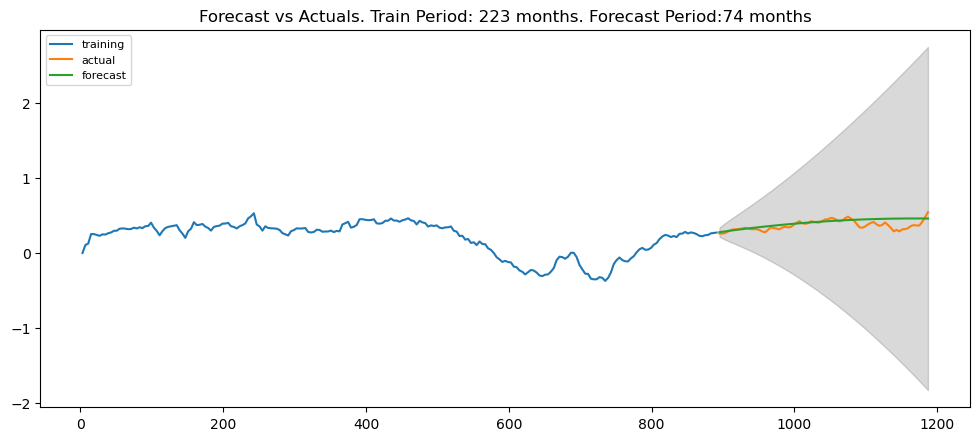

{'pdq_val': '(1, 2, 2)', 'mape': 0.139, 'me': 0.036, 'mae': 0.048, 'mpe': 0.111, 'rmse': 0.065, 'corr': 0.568, 'minmax': 0.111}


In [131]:
#a pdq value of 1,2,2 seems to yield the most accurate results. Let's plot the final values

ArimaModel(df,(1,2,2), .75) 

### Run through the same forecasting process, forecasting the actual home values vs. the percentage change

In [132]:
#define df with clusters and zip codes
clusters = clustered[['ZipCode','labels']]

In [133]:
dfMonthlyPrice = pd.read_pickle('MonthlyPrices')
dfMonthlyPrice

,ZipCode,Date,Price,chg
4403167,501,2008-01-31,119481.0,0.000000
4433534,501,2008-02-29,119218.0,-0.002201
4463901,501,2008-03-31,119363.0,0.001216
4494268,501,2008-04-30,118971.0,-0.003284
4524635,501,2008-05-31,118650.0,-0.002698
...,...,...,...,...
8883995,99929,2020-05-31,237894.0,0.004306
8914362,99929,2020-06-30,238640.0,0.003136
8944729,99929,2020-07-31,239688.0,0.004392
8975096,99929,2020-08-31,240718.0,0.004297


In [134]:
# merge the monthly absolute prices with the clusters
prices_monthly = dfMonthlyPrice.merge(clusters, on = 'ZipCode')


In [135]:
#filter to cluster 2
prices_monthly = prices_monthly.drop(columns = 'chg')
df = prices_monthly[prices_monthly.labels == 3]

In [136]:
df = pd.DataFrame(df.groupby('Date')['Price'].mean())
df

,Price
Date,
1996-01-31,88835.635223
1996-02-29,88917.151387
1996-03-31,89018.471648
1996-04-30,89225.683095
1996-05-31,89436.210210
...,...
2020-05-31,177020.338809
2020-06-30,177727.557145
2020-07-31,178543.989048


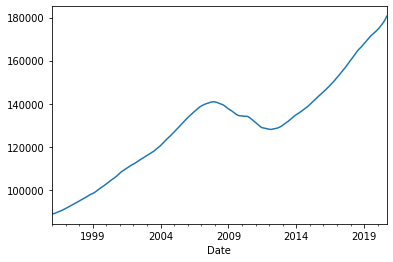

In [137]:
df['Price'].plot()

In [138]:
adf_test(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                   0.777946
p-value                          0.991272
#Lags Used                      16.000000
Number of Observations Used    280.000000
Critical Value (1%)             -3.453922
Critical Value (5%)             -2.871918
Critical Value (10%)            -2.572300
dtype: float64


In [139]:
adf_test(df['Price'].diff().diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.797250
p-value                          0.058668
#Lags Used                      16.000000
Number of Observations Used    278.000000
Critical Value (1%)             -3.454094
Critical Value (5%)             -2.871993
Critical Value (10%)            -2.572340
dtype: float64


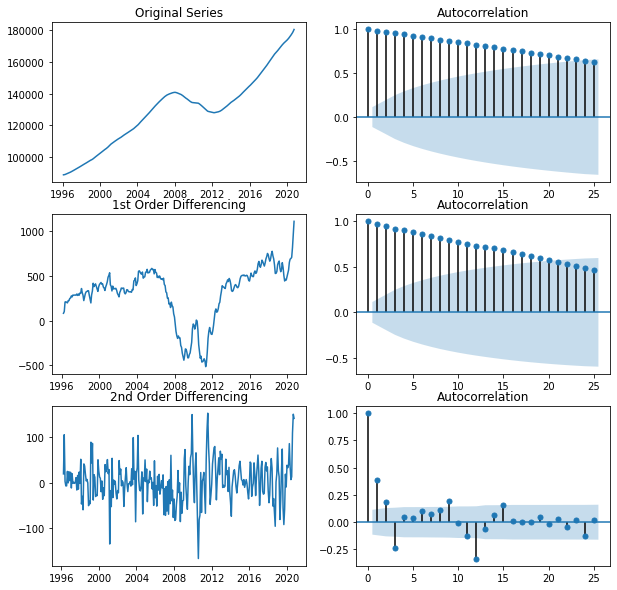

In [140]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize = (10,10))

axes[0, 0].plot(df['Price']); axes[0, 0].set_title('Original Series')
plot_acf(df['Price'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Price'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Price'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Price'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Price'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

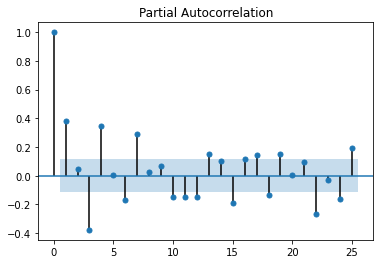

In [141]:
_ = plot_pacf(df['Price'].diff().diff().dropna())

In [142]:
# create list with pdq combinatiosn
import itertools
import warnings
p = range(1,3)
d = range(2,3)
q = range(1,4)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
warnings.filterwarnings("ignore")
pdq

[(1, 2, 1), (1, 2, 2), (1, 2, 3), (2, 2, 1), (2, 2, 2), (2, 2, 3)]

In [143]:
dfs = []
for n in pdqs:
    try:
        dfs.append(pd.DataFrame(ArimaVal(df, n, .90), index = [1]))
    except:
        print('N/A')
        
        
accuracy_metrics = pd.concat(dfs).sort_values(by = 'mape')

Filtering on cluster #2 while using a pdq of 1,2,1 predicts the next 30 monhts with a RMSE of 2,509

In [144]:
accuracy_metrics

,pdq_val,mape,me,mae,mpe,rmse,corr,minmax
1,"(1, 2, 1)",0.010,1685.727,1714.018,0.010,2152.679,0.998,0.010
1,"(2, 2, 1)",0.010,1771.874,1798.586,0.010,2257.433,0.998,0.010
1,"(1, 2, 3)",0.015,2572.164,2572.164,0.015,3150.532,0.998,0.014
1,"(2, 2, 3)",0.015,2618.442,2618.442,0.015,3201.443,0.998,0.015
1,"(1, 2, 2)",0.016,2864.336,2864.336,0.016,3492.591,0.998,0.016
1,"(2, 2, 2)",0.016,2803.102,2803.102,0.016,3421.474,0.998,0.016


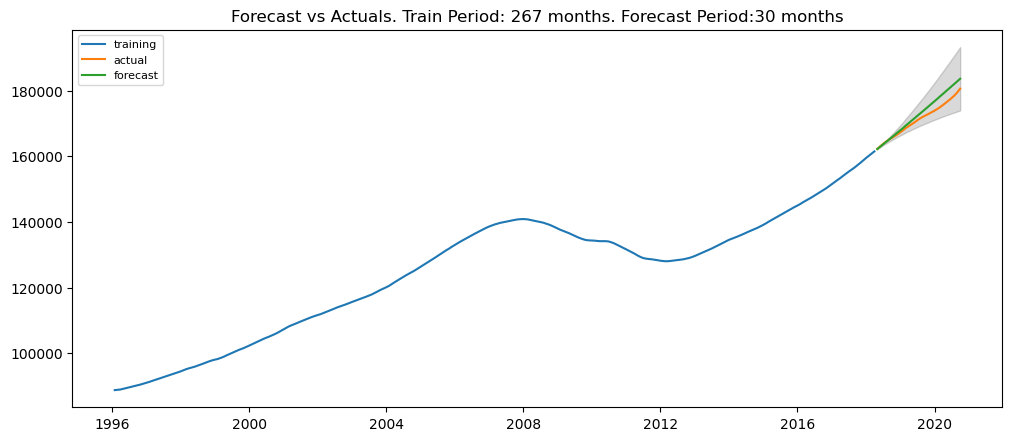

{'pdq_val': '(1, 2, 1)', 'mape': 0.01, 'me': 1685.727, 'mae': 1714.018, 'mpe': 0.01, 'rmse': 2152.679, 'corr': 0.998, 'minmax': 0.01}


In [145]:
ArimaModel(df,(1,2,1), .90) 

Cluster 2 Looks to be a good set for predictive modeling and investment. Let's export the set for further analysis

In [148]:

dfHomeValue = pd.read_pickle('HomeValues')
MonthlyHomeValues = dfMonthlyPrice.merge(clusters, on = 'ZipCode')
MonthlyHomeValues = MonthlyHomeValues.merge(dfHomeValue[['ZipCode','City','State','Metro']], on = 'ZipCode')
MonthlyHomeValues

,ZipCode,Date,Price,chg,labels,City,State,Metro
0,1001,1996-01-31,107177.0,0.000000,0,Agawam,MA,Springfield
1,1001,1996-02-29,107337.0,0.001493,0,Agawam,MA,Springfield
2,1001,1996-03-31,107736.0,0.003717,0,Agawam,MA,Springfield
3,1001,1996-04-30,108221.0,0.004502,0,Agawam,MA,Springfield
4,1001,1996-05-31,108519.0,0.002754,0,Agawam,MA,Springfield
...,...,...,...,...,...,...,...,...
3942670,99587,2020-05-31,346390.0,-0.000017,3,Anchorage,AK,Anchorage
3942671,99587,2020-06-30,346919.0,0.001527,3,Anchorage,AK,Anchorage
3942672,99587,2020-07-31,350461.0,0.010210,3,Anchorage,AK,Anchorage
3942673,99587,2020-08-31,353775.0,0.009456,3,Anchorage,AK,Anchorage


In [149]:
MonthlyHomeValues.to_pickle('HomeVals_Clustered')
